In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18, vgg19, resnet50, resnext50_32x4d
from google.colab import drive, files
from collections import Counter
import seaborn as sns
from torchsummary import summary

In [ ]:

# Mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

my_drive_path = '/content/drive/MyDrive/CS5242_Project/model_checkpoints_resnext/'
data_root_path = '/content/drive/MyDrive/cs52425242/frames/'
resnet_drive_path = '/content/drive/MyDrive/CS5242_Project/model_checkpoints_resnet/'
train_path = data_root_path + 'train/'
test_path = data_root_path + 'test/'

We calculate the Mean and Standard Deviation of the training images here. They shall be used for normalizing the training and test datasets.

In [ ]:
def batch_mean_and_std(dataloader):

    count = 0
    fst_moment = torch.empty(3).to(device)
    snd_moment = torch.empty(3).to(device)

    for images, _ in tqdm(dataloader):
      images = images.to(device)
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_squares = torch.sum(images ** 2, dim=[0, 2, 3])
      fst_moment = (count * fst_moment + sum_) / (count + nb_pixels)
      snd_moment = (count * snd_moment + sum_of_squares) / (count + nb_pixels)
      count += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return mean, std

In [ ]:
data_transform_without_normalization = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

image_dataset_train = datasets.ImageFolder(root=train_path, transform=data_transform_without_normalization)
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=20, shuffle=False, num_workers=2)

In [ ]:
# DO NOT RUN this block unless you want to recalculate the mean and standard deviation of the training dataset
train_mean, train_std = batch_mean_and_std(dataloader_train)
print('Mean of training images = {}, Std of training images = {}'.format(train_mean, train_std))

100%|██████████| 1071/1071 [1:28:53<00:00,  4.98s/it]


Mean of training images = tensor([0.4268, 0.4069, 0.3794], device='cuda:0'), Std of training images = tensor([0.2792, 0.2735, 0.2714], device='cuda:0')


We take random samples from the training dataset and normalize them using the Mean and Standard Deviation calculated above. We also normalize the random samples using the Mean and Standard Deviation of the ImageNet dataset. We visualize all of these below.

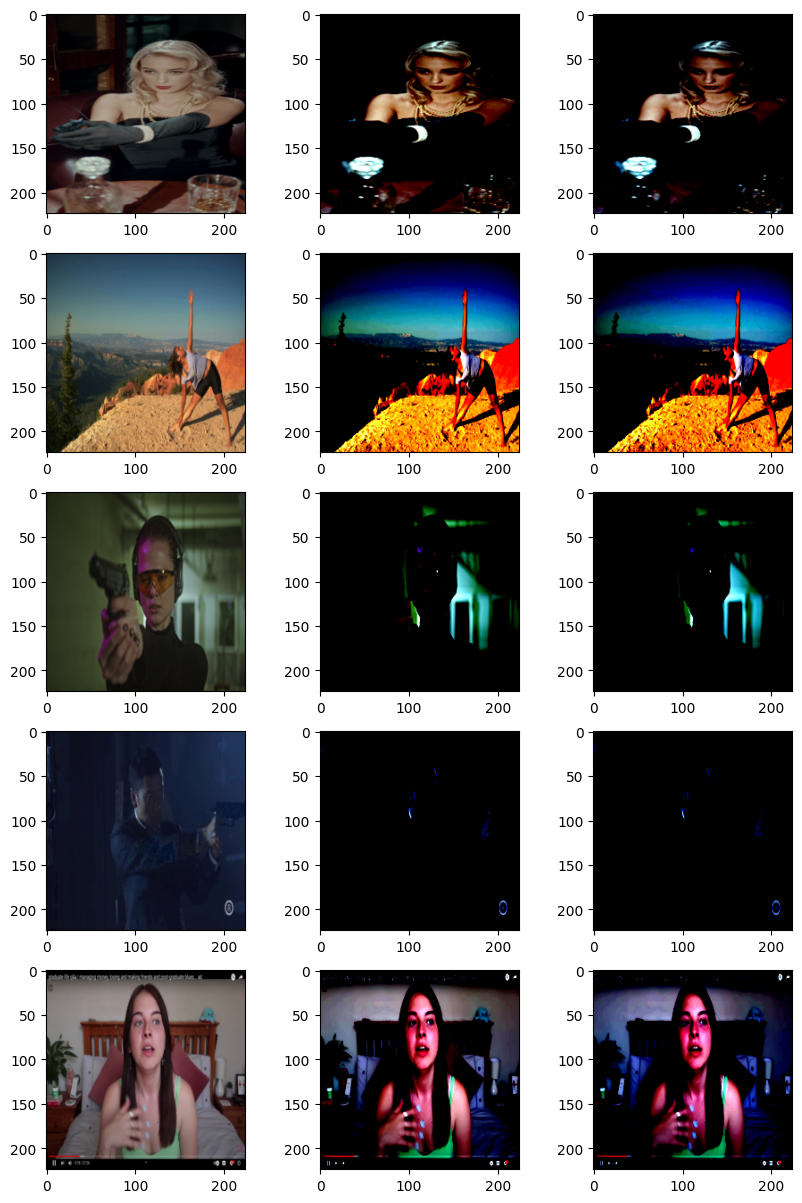

In [ ]:
# Display 5 random images from the training dataset
# Left: actual image, Middle: normalized image using derived mean and std, Right: normalized image using ImageNet mean and std
# We shall use the derive mean and std that has been calculated from the training dataset

train_mean, train_std = [0.4268, 0.4069, 0.3794], [0.2792, 0.2735, 0.2714]
normalize_transform_actual = transforms.Normalize(mean=train_mean, std=train_std)
normalize_transform_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def display_images(num_images=5):
  idx_list = torch.randint(0, len(image_dataset_train), (num_images,))
  f, axarr = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))
  i = 0
  for idx in idx_list:
    sample_idx_orig = image_dataset_train[idx][0].permute(1, 2, 0).cpu()
    sample_idx_norm_actual = normalize_transform_actual(image_dataset_train[idx][0]).permute(1, 2, 0).cpu()
    sample_idx_norm_imagenet = normalize_transform_imagenet(image_dataset_train[idx][0]).permute(1, 2, 0).cpu()
    axarr[i, 0].imshow(sample_idx_orig)
    axarr[i, 1].imshow(sample_idx_norm_actual)
    axarr[i, 2].imshow(sample_idx_norm_imagenet)
    i += 1

display_images()

We divide the training dataset in the ratio 4:1 with 4 parts to be used for training and 1 part to be used for validation. The training, validation and test dataloaders are prepared next.

In [ ]:
train_mean, train_std = [0.4268, 0.4069, 0.3794], [0.2792, 0.2735, 0.2714]
# ImageNet Norm: Mean = [0.485, 0.456, 0.406], Std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=train_mean, std=train_std)])

dataset_train = datasets.ImageFolder(root=train_path, transform=data_transforms)

train_idx, val_idx = train_test_split(list(range(len(dataset_train))), test_size=0.2, shuffle=True, random_state=0, stratify=dataset_train.targets)

image_datasets = {'train': Subset(dataset_train, train_idx),
                  'validation': Subset(dataset_train, val_idx),
                  'test': datasets.ImageFolder(root=test_path, transform=data_transforms)}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=20, shuffle=True, num_workers=2),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=20, shuffle=False, num_workers=2),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=20, shuffle=False, num_workers=2)}

print('Labels = {}'.format(image_datasets['test'].class_to_idx))

print('Training dataset size = {}'.format(len(image_datasets['train'])))
# print('Training dataset distribution: {}'.format(dict(Counter(image_datasets['train']))))

print('Validation dataset size = {}'.format(len(image_datasets['validation'])))
# print('Validation dataset distribution: {}'.format(dict(Counter(image_datasets['validation']))))

print('Test dataset size = {}'.format(len(image_datasets['test'])))


Labels = {'norm': 0, 'weap': 1}
Training dataset size = 17131
Validation dataset size = 4283
Test dataset size = 4053


The below method generates the model used in this project. The EfficientNet with pretrained parameters is used as the baseline model. We add our own fully-connected layers with a dropout of 0.5.

In [ ]:
def create_model(base_model=resnet50):
  model = base_model(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

    model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, 2))

    model = model.to(device)
    return model

This is the method to save the model after every epoch during training. We also save other metrics like the training loss, training accuracy, validation loss and validation accuracy observed for a particular epoch in the checkpoint so that they can be later used for generating visualizations.

In [ ]:
def save_model(model, optimizer, epoch, train_loss, train_acc, val_loss, val_acc):
  colab_checkpoint_path = my_drive_path + 'training_checkpoint_epoch_' + str(epoch) + '.pth'
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
            }, colab_checkpoint_path)
  print('{} checkpoint for epoch {} saved...'.format(colab_checkpoint_path, epoch))

This is the method which trains the model on the training data and then validates it on the validation dataset for the specified number of epochs. It invokes the save_model() method above to save the model checkpoint after every epoch.

In [ ]:
def train_model(model, loss_fn, optimizer, device, epoch_to_start, n_epochs=5):
  epoch_train_loss_list, epoch_validation_loss_list = [], []
  epoch_train_acc_list, epoch_validation_acc_list = [], []
  for epoch in range(epoch_to_start, epoch_to_start + n_epochs):
    print('Epoch {}/{}'.format(epoch, epoch_to_start + n_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss, running_corrects = 0, 0
      for i, data in tqdm(enumerate(dataloaders[phase])):
          x_batch, y_batch = data
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)

          yhat = model(x_batch)
          loss = loss_fn(yhat, y_batch)

          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          _, preds = torch.max(yhat, 1)
          running_loss += loss.item() * x_batch.size(0)
          running_corrects += torch.sum(preds == y_batch.data)

      epoch_loss = running_loss / len(image_datasets[phase])
      epoch_acc = running_corrects.double() / len(image_datasets[phase])

      print(' {} :: loss = {:.4f}, acc = {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
        epoch_train_loss_list.append(epoch_loss)
        epoch_train_acc_list.append(epoch_acc)
      else:
        epoch_validation_loss_list.append(epoch_loss)
        epoch_validation_acc_list.append(epoch_acc)
        save_model(model, optimizer, epoch, epoch_train_loss_list[-1], epoch_train_acc_list[-1], epoch_validation_loss_list[-1], epoch_validation_acc_list[-1])

  return model, epoch_train_loss_list, epoch_train_acc_list, epoch_validation_loss_list, epoch_validation_acc_list

In [ ]:
#base model
base_model = resnext50_32x4d
# Create model
model = create_model(base_model)

# Cross Entropy with Sigmoid, so no need to use Sigmoid separately in the model
loss_fn = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.fc.parameters())

# Set this parameter to True if you want to continue training from a saved checkpoint onwards
load_checkpoint = False
# Checkpoint filename to load if load_checkpoint = True
checkpoint_file_to_load = 'training_checkpoint_epoch_13.pth'

if load_checkpoint:
  if device == 'cpu':
    checkpoint = torch.load(my_drive_path + checkpoint_file_to_load, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(my_drive_path + checkpoint_file_to_load)

  print('Loaded {} checkpoint...'.format(checkpoint_file_to_load))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_to_start = checkpoint['epoch'] + 1
  print('Will start training from epoch {} onwards...'.format(epoch_to_start))
else:
  epoch_to_start = 1

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 89.6MB/s]


Loaded training_checkpoint_epoch_13.pth checkpoint...
Will start training from epoch 14 onwards...


In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Train the model and save the network parameters
trained_model, epoch_train_loss_list, epoch_train_acc_list, epoch_validation_loss_list, epoch_validation_acc_list = train_model(model, loss_fn, optimizer, device, epoch_to_start, n_epochs=3)

Epoch 14/16
----------


857it [1:24:35,  5.92s/it]

 train :: loss = 0.3419, acc = 0.8393



215it [21:13,  5.92s/it]


 validation :: loss = 0.2451, acc = 0.8959
/content/drive/MyDrive/CS5242_Project_Local/model_checkpoints/training_checkpoint_epoch_14.pth checkpoint for epoch 14 saved...
Epoch 15/16
----------


857it [12:00,  1.19it/s]

 train :: loss = 0.3187, acc = 0.8547



215it [02:52,  1.24it/s]


 validation :: loss = 0.2350, acc = 0.9038
/content/drive/MyDrive/CS5242_Project_Local/model_checkpoints/training_checkpoint_epoch_15.pth checkpoint for epoch 15 saved...
Epoch 16/16
----------


857it [11:54,  1.20it/s]

 train :: loss = 0.3194, acc = 0.8455



215it [02:53,  1.24it/s]


 validation :: loss = 0.2495, acc = 0.8917
/content/drive/MyDrive/CS5242_Project_Local/model_checkpoints/training_checkpoint_epoch_16.pth checkpoint for epoch 16 saved...


In [ ]:
# Generate plot of Training and Validation metrics against Epochs
checkpoint_file_template = my_drive_path + 'training_checkpoint_epoch_{}.pth'
max_epoch = 16
train_loss_list, train_acc_list, validation_loss_list, validation_acc_list = [], [], [], []
epochs = range(1, max_epoch + 1)

for epoch in epochs:
  checkpoint_file = checkpoint_file_template.format(epoch)
  if device == 'cpu':
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(checkpoint_file)

  train_loss_list.append(checkpoint['train_loss'])
  train_acc_list.append(checkpoint['train_acc'].cpu())
  validation_loss_list.append(checkpoint['val_loss'])
  validation_acc_list.append(checkpoint['val_acc'].cpu())

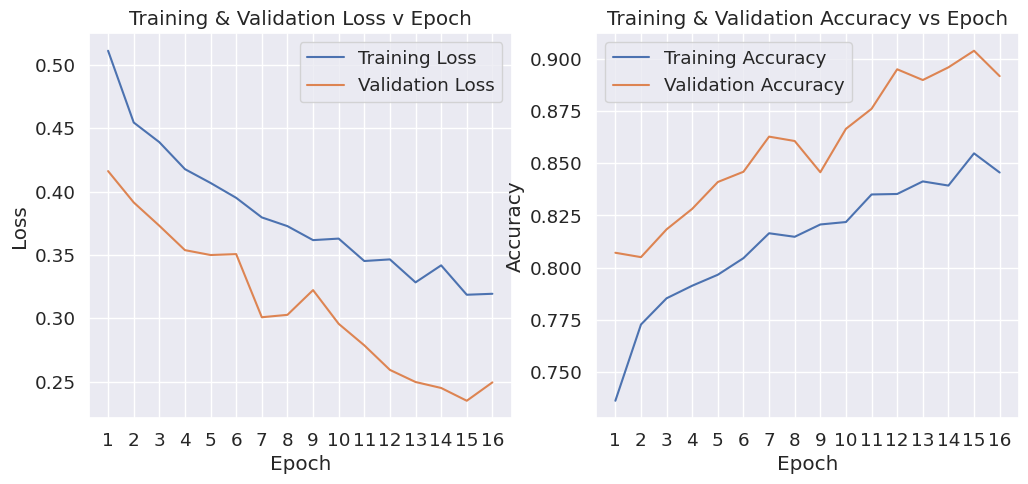

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, train_loss_list, label='Training Loss')
axes[0].plot(epochs, validation_loss_list, label='Validation Loss')
axes[0].legend(loc='upper right')
axes[0].set_xticks(epochs, epochs)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss v Epoch')

axes[1].plot(epochs, train_acc_list, label='Training Accuracy')
axes[1].plot(epochs, validation_acc_list, label='Validation Accuracy')
axes[1].legend(loc='upper left')
axes[1].set_xticks(epochs, epochs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy vs Epoch')

fig.savefig(my_drive_path + 'Training_Validation_Loss_Accuracy_vs_Epoch.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
# Generate plot of Training and Validation metrics against Epochs
resnet_checkpoint_file_template = resnet_drive_path + 'training_checkpoint_epoch_{}.pth'

resnet_max_epoch = 14
resnet_train_loss_list, resnet_train_acc_list, resenet_validation_loss_list, resnet_validation_acc_list = [], [], [], []

resnet_epochs = range(1, resnet_max_epoch + 1)


for epoch in resnet_epochs:
  resnet_checkpoint_file = resnet_checkpoint_file_template.format(epoch)
  if device == 'cpu':
    resnet_checkpoint = torch.load(resnet_checkpoint_file, map_location=torch.device('cpu'))
  else:
    resnet_checkpoint = torch.load(resnet_checkpoint_file)
  resnet_train_loss_list.append(resnet_checkpoint['train_loss'])
  resnet_train_acc_list.append(resnet_checkpoint['train_acc'].cpu())
  resenet_validation_loss_list.append(resnet_checkpoint['val_loss'])
  resnet_validation_acc_list.append(resnet_checkpoint['val_acc'].cpu())

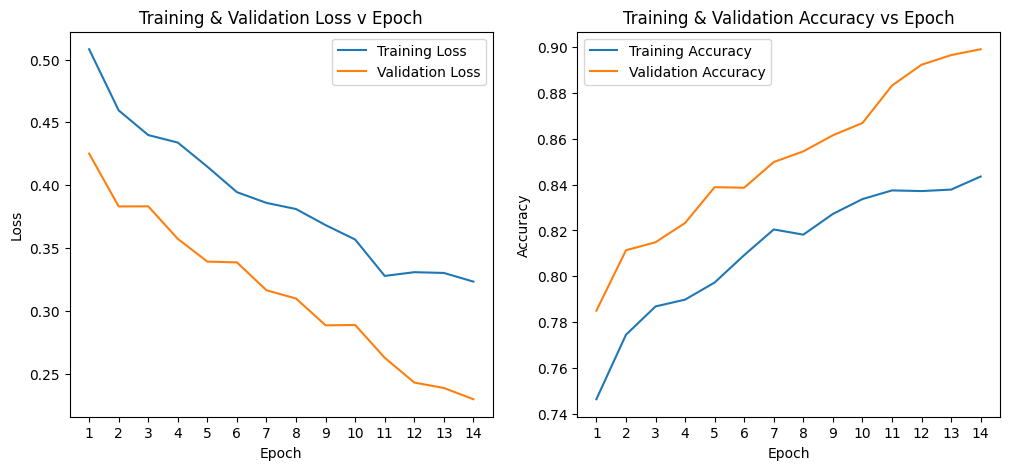

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(resnet_epochs, resnet_train_loss_list, label='Training Loss')
axes[0].plot(resnet_epochs, resenet_validation_loss_list, label='Validation Loss')
axes[0].legend(loc='upper right')
axes[0].set_xticks(resnet_epochs, resnet_epochs)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss v Epoch')

axes[1].plot(resnet_epochs, resnet_train_acc_list, label='Training Accuracy')
axes[1].plot(resnet_epochs, resnet_validation_acc_list, label='Validation Accuracy')
axes[1].legend(loc='upper left')
axes[1].set_xticks(resnet_epochs, resnet_epochs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy vs Epoch')

fig.savefig(my_drive_path + 'Training_Validation_Loss_Accuracy_vs_Epoch.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
resnet_test_model = create_model(resnet50)
# Checkpoint filename to load for testing
resnet_test_checkpoint_file = 'training_checkpoint_epoch_14.pth'

if device == 'cpu':
    resnet_test_checkpoint = torch.load(resnet_drive_path + resnet_test_checkpoint_file, map_location=torch.device('cpu'))
else:
    resnet_test_checkpoint = torch.load(resnet_drive_path + resnet_test_checkpoint_file)
resnet_test_model.load_state_dict(resnet_test_checkpoint['model_state_dict'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 355MB/s]


<All keys matched successfully>

In [ ]:
resnext_test_model = create_model(base_model)
# Checkpoint filename to load for testing
resnext_test_checkpoint_file = 'training_checkpoint_epoch_15.pth'

if device == 'cpu':
    resnext_test_checkpoint = torch.load(my_drive_path + resnext_test_checkpoint_file, map_location=torch.device('cpu'))
else:
    resnext_test_checkpoint = torch.load(my_drive_path + resnext_test_checkpoint_file)
resnext_test_model.load_state_dict(resnext_test_checkpoint['model_state_dict'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
def run_test(model):
  model.eval()

  preds_list, y_batch_list = [], []
  for i, data in tqdm(enumerate(dataloaders['test'])):
    x_batch, y_batch = data
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    yhat = model(x_batch)
    _, preds = torch.max(yhat, 1)
    preds_list.append(preds.cpu())
    y_batch_list.append(y_batch.cpu())

  all_preds = np.concatenate(preds_list)
  all_y_batch = np.concatenate(y_batch_list)

  return all_y_batch, all_preds

In [ ]:
reals_y, resnext_preds_y = run_test(resnext_test_model)

203it [13:17,  3.93s/it]


In [ ]:
reals_y, resnet_preds_y = run_test(resnet_test_model)

203it [02:06,  1.60it/s]


Test Metrics:
Accuracy = 0.7538, Precision = 0.7615, Recall = 0.7928, F1-score = 0.7768

True Positives = 1737
True Negatives = 1318
False Positives = 544
False Negatives = 454



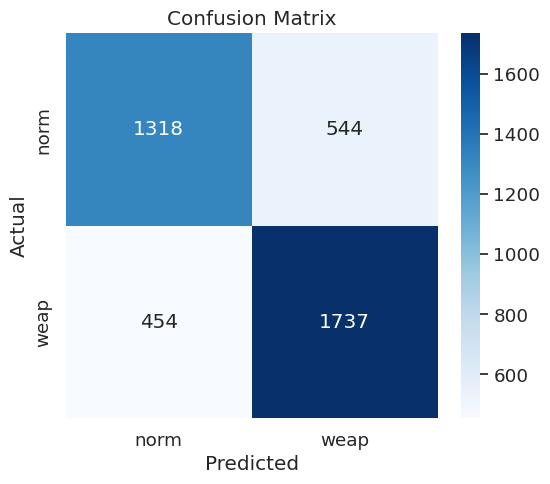

In [ ]:
# Take the average of predicted probabilities from both models
ensemble_preds_y = np.round((resnext_preds_y + resnet_preds_y) / 2)


# Calculate test metrics for the ensemble
accuracy = round(metrics.accuracy_score(reals_y, ensemble_preds_y), 4)
precision = round(metrics.precision_score(reals_y, ensemble_preds_y), 4)
recall = round(metrics.recall_score(reals_y, ensemble_preds_y), 4)
f1_score = round(metrics.f1_score(reals_y, ensemble_preds_y), 4)

print('Test Metrics:')
print('Accuracy = {}, Precision = {}, Recall = {}, F1-score = {}'.format(accuracy, precision, recall, f1_score))
print()

cf_matrix = metrics.confusion_matrix(reals_y, ensemble_preds_y)
tn, fp, fn, tp = cf_matrix.ravel()
print('True Positives = {}'.format(tp))
print('True Negatives = {}'.format(tn))
print('False Positives = {}'.format(fp))
print('False Negatives = {}'.format(fn))
print()

cf_matrix_df = pd.DataFrame(cf_matrix,
                            index=['norm', 'weap'],
                            columns=['norm', 'weap'])
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(cf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(my_drive_path + 'ConfusionMatrix.pdf', format='pdf', bbox_inches='tight')
plt.show()


Test Metrics:
Accuracy = 0.7281, Precision = 0.6932, Recall = 0.8918, F1-score = 0.78

True Positives = 1954
True Negatives = 997
False Positives = 865
False Negatives = 237



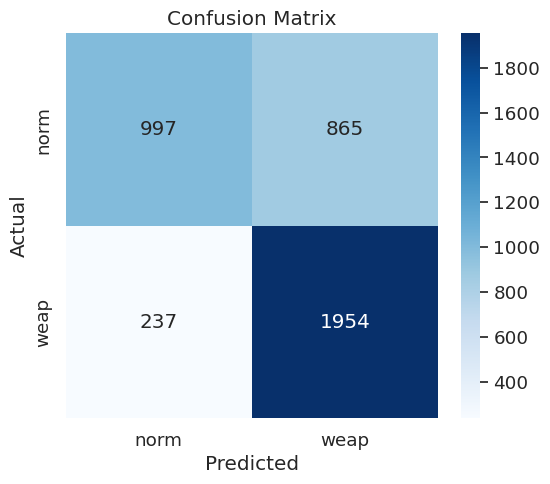

In [ ]:
accuracy = round(metrics.accuracy_score(reals_y, resnext_preds_y), 4)
precision = round(metrics.precision_score(reals_y, resnext_preds_y), 4)
recall = round(metrics.recall_score(reals_y, resnext_preds_y), 4)
f1_score = round(metrics.f1_score(reals_y, resnext_preds_y), 4)

print('Test Metrics:')
print('Accuracy = {}, Precision = {}, Recall = {}, F1-score = {}'.format(accuracy, precision, recall, f1_score))
print()

cf_matrix = metrics.confusion_matrix(reals_y, resnext_preds_y)
tn, fp, fn, tp = cf_matrix.ravel()
print('True Positives = {}'.format(tp))
print('True Negatives = {}'.format(tn))
print('False Positives = {}'.format(fp))
print('False Negatives = {}'.format(fn))
print()

cf_matrix_df = pd.DataFrame(cf_matrix,
                            index=['norm', 'weap'],
                            columns=['norm', 'weap'])
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(cf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(my_drive_path + 'ConfusionMatrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

Test Metrics:
Accuracy = 0.7399, Precision = 0.7251, Recall = 0.8357, F1-score = 0.7765

True Positives = 1831
True Negatives = 1168
False Positives = 694
False Negatives = 360



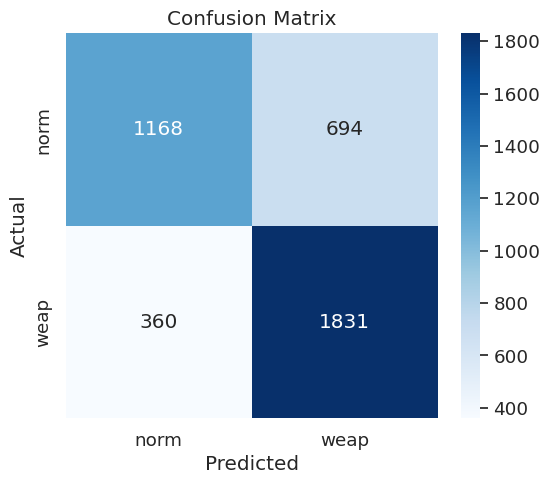

In [ ]:
accuracy = round(metrics.accuracy_score(reals_y, resnet_preds_y), 4)
precision = round(metrics.precision_score(reals_y, resnet_preds_y), 4)
recall = round(metrics.recall_score(reals_y, resnet_preds_y), 4)
f1_score = round(metrics.f1_score(reals_y, resnet_preds_y), 4)

print('Test Metrics:')
print('Accuracy = {}, Precision = {}, Recall = {}, F1-score = {}'.format(accuracy, precision, recall, f1_score))
print()

cf_matrix = metrics.confusion_matrix(reals_y, resnet_preds_y)
tn, fp, fn, tp = cf_matrix.ravel()
print('True Positives = {}'.format(tp))
print('True Negatives = {}'.format(tn))
print('False Positives = {}'.format(fp))
print('False Negatives = {}'.format(fn))
print()

cf_matrix_df = pd.DataFrame(cf_matrix,
                            index=['norm', 'weap'],
                            columns=['norm', 'weap'])
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(cf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(my_drive_path + 'ConfusionMatrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Demonstration using test data

image_dataset_test = datasets.ImageFolder(root=test_path, transform=data_transform_without_normalization)
normalize_transform_actual = transforms.Normalize(mean=train_mean, std=train_std)

idx_to_class = {v: k for k, v in image_dataset_test.class_to_idx.items()}

def predict_random_samples(model, num_images=5):
  model.eval()

  idx_list = torch.randint(0, len(image_dataset_test), (num_images,))
  for idx in idx_list:
    sample_idx_orig = image_dataset_test[idx][0]
    sample_idx_norm = normalize_transform_actual(sample_idx_orig)
    sample_idx_input = torch.unsqueeze(sample_idx_norm, dim=0).to(device)
    pred_logits_tensor = model(sample_idx_input)

    fig, axarr = plt.subplots(1, 2, figsize=(8, 4))
    axarr[0].set_title('Actual Image', fontsize=10)
    axarr[0].imshow(sample_idx_orig.permute(1, 2, 0).cpu())
    axarr[0].grid(False)
    axarr[1].set_title('Normalized Image', fontsize=10)
    axarr[1].imshow(sample_idx_norm.permute(1, 2, 0).cpu())
    axarr[1].grid(False)

    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
    fig.suptitle('norm = {:.3f} , weap = {:.3f} , Prediction = {}'.format(pred_probs[0, 0], pred_probs[0, 1], idx_to_class[np.argmax(pred_probs)]), fontsize=12)
    fig.tight_layout()

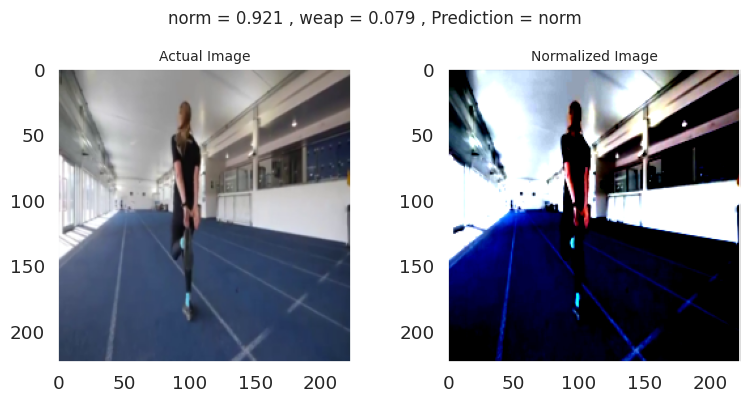

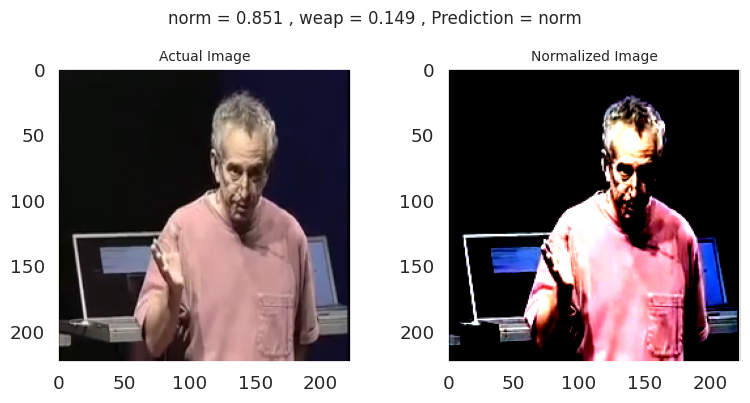

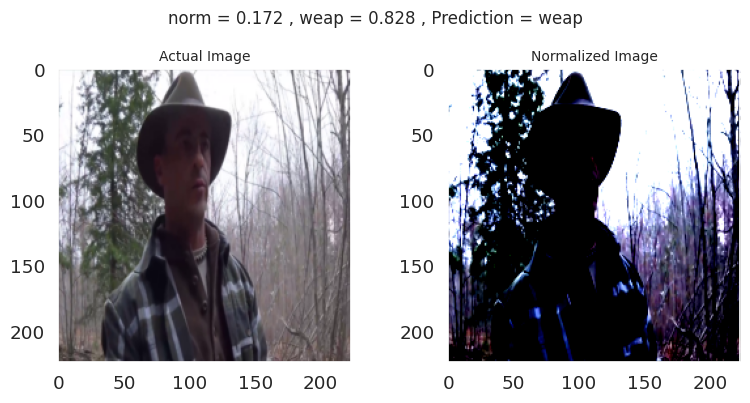

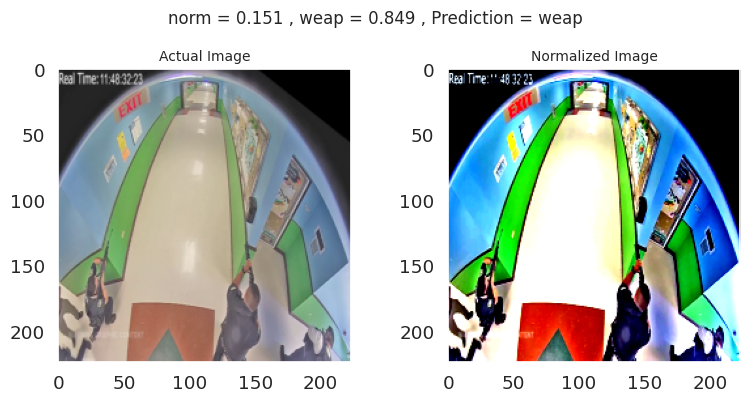

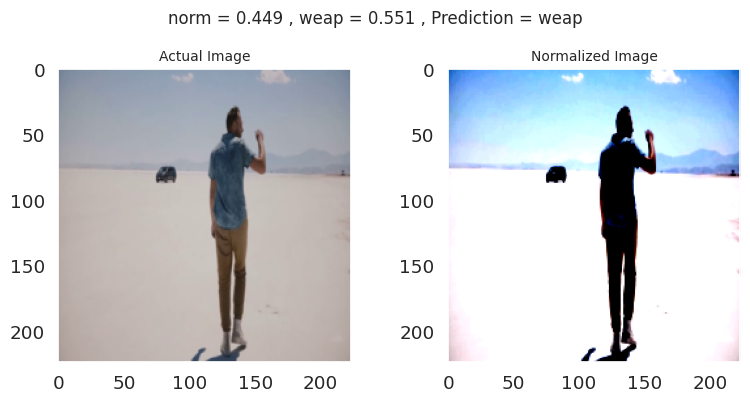

In [ ]:
predict_random_samples(resnext_test_model)